In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pybullet as p
import pybullet_data
import time
import random
import cv2
from decimal import Decimal
import os
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [6]:
# Bicycle and its environment

"""
Action Space = 1 (position of handlebar)
Obs Space = 25
"""

#del env
cv2.destroyAllWindows()

class CycleBalancingEnv(gym.Env):
    metadata = {'render.modes': ['human']}  
  
    def __init__(self):
        # Out cycle has only 1 action spaces i.e. the position of the handlebar
        self.action_space = gym.spaces.box.Box(
            low=-1 * np.ones(1, dtype=np.float32),
            high=1 * np.ones(1, dtype=np.float32))
        # Obervation space
        self.observation_space = gym.spaces.box.Box(
            low=-1 * np.ones(25, dtype=np.float32),
            high=1 * np.ones(25, dtype=np.float32))
        self.np_random, _ = gym.utils.seeding.np_random()

        if not p.isConnected():
            self.client = p.connect(p.GUI) # Physics + Visual
            #self.client = p.connect(p.DIRECT) # Only Physics, no visualization. For faster training
        else:
            self.client = 1
            
        p.resetSimulation(self.client)
        p.setRealTimeSimulation(0)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        
        self.n_target = 100 #Number of obstacles
        self.min_target_dist = 15 #Minimum distance of obstacles from bike
        self.target_span = 100 #Maximum distance of obstacles from bike
        self.sphere_dist = 1.5
        
        self.pole = []
        self.plane=p.loadURDF("plane.urdf",[0,0,0], useFixedBase=True) #Loading the Plane Surface
        self.bike = 0 #Index of the Bike
        self.angle_span = 20 #The Angle between two consecutive rays
        self.n_episodes = 0 #Count of the number of episodes
        self.rays_distance = 30 #The max length of the rays
        self.z_balance = -0.25 #Offset between the Bike's center of gravity and the height from which rays are passed
        self.z_target = -1
        self.target_body = -1
        self.width = 1920 #Width of Visual Output
        self.height = 1080 #Height of Visual Output
        self.video=cv2.VideoWriter('video.avi',-1,30,(self.width,self.height)) #For saving the output
        self.img_cnt = 0
        
        self.make_obstacles()
        self.reset()
        #self.show_img()
        
    #Helper (Debugger) function to show the distance traveled by rays in all direction
    def show_img(self):
        
        self.img = np.zeros((800,800,3), dtype='float32')
        shift = 400
        multiply = 400
        ls = p.getBasePositionAndOrientation(self.bike)
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        mini = 1000
        for deg in range(1, 361, 1):
            mini = min(mini, self.dist[deg-1])
            if deg%self.angle_span==0:
                rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
                rad = float(rad)
                start = (int(shift + bike_x + self.sphere_dist*np.cos(rad)), int(shift + bike_y + self.sphere_dist*np.sin(rad)))
                end = (int(shift + bike_x + mini*multiply*np.cos(rad)), int(shift + bike_y + mini*multiply*np.sin(rad)))
                cv2.ellipse(self.img, start, (int(mini*multiply),int(mini*multiply)), 0, (rad*180/np.pi)-self.angle_span, (rad*180/np.pi), (0,0,255), -1)
                mini = 1000
            
        cv2.imshow('img', cv2.rotate(cv2.transpose(self.img), cv2.ROTATE_180))
        #cv2.imshow('img', self.img)
        cv2.waitKey(1)
        #cv2.destroyAllWindows()

    
    def apply_action(self, action):
        p.setJointMotorControl2(self.bike, 0, p.POSITION_CONTROL, targetPosition=action[0], maxVelocity=5) # Apply Position control to Handlebar
    
    
    def apply_torque_wheels(self):
        p.setJointMotorControl2(self.bike,1,p.TORQUE_CONTROL , force=(2.5+0)*10000) # Apply Toruqe to Back Wheel
        p.setJointMotorControl2(self.bike,2,p.TORQUE_CONTROL , force=(2.5+0)*10000) # Apply Toruqe to Front Wheel
        
        
    def gyroscope_torque(self):
        ls = p.getBasePositionAndOrientation(self.bike) # ls[0]=Postion of cycle, ls[1] = Orientation of cycle
        val = p.getEulerFromQuaternion(ls[1])[0] - 1.57 # Calculating inclination of cycle from vertical
        p.applyExternalTorque(self.bike, -1, [-1000000*val, 0, 0], flags=p.WORLD_FRAME)
        
        
    def add_pos_orien(self):
        ls = p.getBasePositionAndOrientation(self.bike) # ls[0]=Postion of cycle, ls[1] = Orientation of cycle
             
        self.bike_x = ls[0][0]
        self.bike_y = ls[0][1]
        
        # Calculating the position, orientation, velocity of all the joints of the cycle
        self.obs.append(np.arctan( (self.target_x-self.bike_x)/(self.target_y-self.bike_y+0.00001) ))
        ls = p.getBasePositionAndOrientation(self.bike)
        self.obs += p.getEulerFromQuaternion(ls[1])
        #self.obs.append(ls[0][0]/self.target_span)
        #self.obs.append(ls[0][1]/self.target_span)
        self.obs.append((ls[0][0] - self.target_x)/self.target_span)
        self.obs.append((ls[0][1] - self.target_y)/self.target_span)
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        self.obs.append(handlebar_rotation)
        #print(obs)
        
    def add_dist_by_rays(self):
        ls = p.getBasePositionAndOrientation(self.bike) # ls[0]=Postion of cycle, ls[1] = Orientation of cycle
        z = ls[0][2] + self.z_balance
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        reward_2 = 0
        #cnt = 0
        ray_from = []
        ray_to = []        
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        for deg in range(1, 361, 5):
            rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
            rad = float(rad)
            for i in np.arange(0, 3, 1):
                for j in np.arange(-4, 1, 0.5):
                    ray_from.append((bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), z+i))
                    ray_to.append((bike_x + self.rays_distance*np.cos(rad), bike_y + self.rays_distance*np.sin(rad), z+j))
        
        rays = p.rayTestBatch(ray_from, ray_to)
        mini = 1000
        self.dist = []
        mini = 1000
        #assert(len(rays)==360)
        cnt = 0
        for deg in range(1, 361, 5):
            dist = 1
            for i in np.arange(0, 3, 1):
                for j in np.arange(-4, 1, 0.5):
                    tmp = rays[cnt]
                    cnt += 1
                    if tmp[0]!=self.plane: dist = min(dist, tmp[2])
            if dist<mini:
                mini = dist
            self.dist.append(dist)
            if deg!=0 and (deg-1)%self.angle_span==0:
                self.obs.append(mini)
                mini = 1000
                
    def get_obs(self):
        #For storing all the observations which will be used by the agent to decide the next action
        self.obs = [] 
        
        #Add bike's position, orientation to the observation space
        self.add_pos_orien() 
        
        #Add info from rays to the observation space (i.e whether rays collided with ant object or not)
        self.add_dist_by_rays()
        
        self.obs = np.array(self.obs, dtype=np.float32)
        
    def get_collision(self):
        tmp = p.getContactPoints(self.bike)
        reward_2 = 0
        for i in range(len(tmp)):
            if tmp[i][2]!=0:
                reward_2 = -700
                self.done = True
        return reward_2
    
    def check_outside_range(self):
        dist_2 = np.sqrt((self.bike_x)**2 + abs(self.bike_y)**2)
        reward_3 = 0
        if dist_2 > (self.target_span+30): 
            self.done = True
            reward_3 = -100
            print("Outside Range!")
        if self.time%10==0 and dist_2>self.distance: 
            self.distance = dist_2
            
        if self.time>999:
            reward_3 = -500
            
        return reward_3
        
    def prevent_rotating_in_a_cycle(self):
        ls = p.getBasePositionAndOrientation(self.bike)
        value = p.getEulerFromQuaternion(p.getLinkState(self.bike, 0)[1])[2] - p.getEulerFromQuaternion(ls[1])[2]
        if value<-1: value += 2*np.pi
        if value>1: value -= 2*np.pi
        #print(value)
        if value < -0.3:
            self.left += 0.1
            self.right = 0
        elif value > 0.3:
            self.left = 0
            self.right += 0.1
        else:
            self.left = 0
            self.right = 0
            
        self.neg_reward = 0
        if self.left>10 or self.right>10:
            print("Slow!!!")
            self.neg_reward = -700
            self.done = True
            
    def check_target_distance(self):
        val = self.target_span
        reward_1 = 0
        dist_3 = np.sqrt( (self.bike_x - self.target_x)**2 + (self.bike_y - self.target_y)**2 )
        if dist_3 < self.target_distance:
            reward_1 = 100 + self.target_reward
            self.target_distance -= 5
            self.target_reward = min(300, self.target_reward*2)
        return reward_1
    
    def check_completion(self):
        self.completed = 0
        dist_3 = np.sqrt( (self.bike_x - self.target_x)**2 + (self.bike_y - self.target_y)**2 )
        if dist_3 < 10:
            reward_1 = 500
            self.completed = 1
            self.done = True
            print("DONE!")
            print(dist_3, self.target_distance)
            self.make_obstacles()
            
    def get_reward(self, reward_1, reward_2, reward_3):
        ls = p.getBasePositionAndOrientation(self.bike)
        return reward_1 - abs(ls[0][0] - self.target_x)/10. - abs(ls[0][1] - self.target_y)/10. + self.neg_reward - self.left - self.right + reward_3 + reward_2
    
    def step(self, action):
        
        self.apply_action(action)
        
        for i in range(3):
            self.apply_torque_wheels() #Apply Torque to the wheels (i.e increase velocity)
            self.gyroscope_torque()#Balancing by applying Torque (In real world, this will be done by gyroscope) 
            p.stepSimulation()
            self.render()
            
            #Saving to the output video
            #img = p.getCameraImage(self.width, self.height, renderer=p.ER_BULLET_HARDWARE_OPENGL)
            #img = cv2.cv2.UMat(np.array(img))
            #img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
            #print(img[2].shape)
            #cv2.imwrite('img_'+str(self.img_cnt), img)
        
        self.get_obs()
        
        reward_2 = self.get_collision()
        
        self.time += 1 # Adding 1 to the time for which the current episode has been running
        
        # Terminating the episode if the cycle covers less than 1 units distance in 200 timesteps
        reward_3 = self.check_outside_range()
            
        self.prevent_rotating_in_a_cycle()
            
        reward_1 = self.check_target_distance()
                    
        self.check_completion()    
        
        # Calculating the total reward
        reward = self.get_reward(reward_1, reward_2, reward_3)

        return self.obs, reward/100, self.done, dict()


    def load_bike(self):
        if self.bike!=0:
            p.removeBody(self.bike)
        if self.target_body!=-1:
            p.removeBody(self.target_body)
        # Loading the cycle
        self.bike_x = 0 # random.randint(-5, 5) # X position of the cycle
        self.bike_y = 0 # random.randint(-5, 5) # Y position of the cycle
        self.bike=p.loadURDF("bike_2.urdf.xml",[self.bike_x, self.bike_y,0], p.getQuaternionFromEuler([0,0, random.random()*2*np.pi]),  useFixedBase=False)
        
    def load_target(self):
        for i in range(1):
            self.target_x = 0
            self.target_y = 0
            dist = np.sqrt( (self.bike_x - self.target_x)**2 + (self.bike_y - self.target_y)**2 )
            while dist<(self.target_span) or dist>(self.target_span+20):
                self.target_x = random.randint(int(self.bike_x) - self.target_span, int(self.bike_x) + self.target_span)
                self.target_y = random.randint(int(self.bike_y) - self.target_span, int(self.bike_y) + self.target_span)
                dist = np.sqrt( (self.bike_x - self.target_x)**2 + (self.bike_y - self.target_y)**2 )
            self.target_body = p.loadURDF(r"cube.urdf",[self.target_x, self.target_y, 10], [0,0,0,1], useFixedBase=True, globalScaling=5.0)
        textureId_3 = p.loadTexture('Texture/green.jpg')
        p.changeVisualShape(self.target_body, -1, textureUniqueId=textureId_3)
        self.target_distance = (np.sqrt( (self.bike_x - self.target_x)**2 + (self.bike_y - self.target_y)**2))//10 * 10
        self.target_reward = 128
    
    def add_dynamics(self):
        # Adding friction and other dynamics
        p.changeDynamics(self.plane, -1, lateralFriction=5, angularDamping=1)
        p.changeDynamics(self.bike, 1, mass=100)
        #p.changeDynamics(self.bike, 2, mass=100, lateralFriction=1, angularDamping=3, rollingFriction=0.01)
        p.changeDynamics(self.bike, -1, lateralFriction=5, angularDamping=1)
        
        p.setGravity(0, 0, -250) # Setting the gravity
    
    def reset(self):
        
        self.n_episodes += 1 #Increase the number of episodes by 1
        
        #Change obstacles's position after every 20 episodes for robust training
        if self.n_episodes==20:
            self.make_obstacles()
            self.n_episodes = 0
        
        self.load_bike()
        
        self.load_target()
        
        for i in range(10):
            p.stepSimulation()
            
        self.add_dynamics()
        
        self.done=False
        self.time = 0
        self.distance = np.sqrt((self.bike_x)**2 + abs(self.bike_y)**2)
        self.neg_reward = 0
        
        # Calculating the initial observation space
        self.get_obs()
        
        self.cnt = 0
        self.left = 0
        self.right = 0
        self.completed = 0
        
        return self.obs

    #Load the Obstacles
    def make_obstacles(self):
        
        p.resetSimulation(self.client)
        p.setRealTimeSimulation(0)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        #self.plane=p.loadURDF("plane.urdf",[0,0,0], useFixedBase=True)
        mul = 100
        height = 2
        visualShift = [0, 0, 0]
        shift = [0, 0, 0]
        meshScale=[0.1*mul, 0.1*mul, 0.1*mul*height]
        groundColId = p.createCollisionShape(shapeType=p.GEOM_MESH, 
                                                  fileName="terrain.obj", 
                                                  collisionFramePosition=shift,
                                                  meshScale=meshScale,
                                                  flags=p.GEOM_FORCE_CONCAVE_TRIMESH)
        groundVisID = p.createVisualShape(shapeType=p.GEOM_MESH, 
                                            fileName="terrain.obj", 
                                            #rgbaColor=[0.7,0.3,0.1,1],
                                            rgbaColor=[1,1,1,1],
                                            specularColor=[0.4,.4,0],
                                            visualFramePosition=visualShift,
                                            meshScale=meshScale)
        self.plane = p.createMultiBody(baseMass=0,
                                              baseInertialFramePosition=[0,0,0],
                                              baseCollisionShapeIndex=groundColId, 
                                              baseVisualShapeIndex=groundVisID, 
                                              basePosition=[0,0,0], 
                                              useMaximalCoordinates=True)
        textureId = p.loadTexture('Texture/surface3.jpg')
        p.changeVisualShape(self.plane, -1, textureUniqueId=textureId)
        self.bike = 0
            
        self.bike_x = 0
        self.bike_y = 0
        self.pole = []
        textureId = p.loadTexture('Texture/surface2.jpg')
        for i in range(self.n_target):
            target_x = self.bike_x
            target_y = self.bike_y
            while (np.sqrt( (self.bike_x - target_x)**2 + (self.bike_y - target_y)**2 )) < self.min_target_dist:
                target_x = random.randint(int(self.bike_x) - self.target_span, int(self.bike_x) + self.target_span)
                target_y = random.randint(int(self.bike_y) - self.target_span, int(self.bike_y) + self.target_span)
            #self.pole.append( p.loadURDF("C:/Users/User/Documents/GitHub/bullet3/examples/pybullet/gym/pybullet_data/cube.urdf",[target_x, target_y, 4], [0,0,0,1], useFixedBase=True, globalScaling=1+ 3*random.random()) )
            self.pole.append(self.make_stone(target_x, target_y))
            #p.changeDynamics(self.pole[i], -1, mass=1000)
            p.changeVisualShape(self.pole[i], -1, textureUniqueId=textureId)
        
    #Load a stone simulation at position "target_x" and "target_y"
    def make_stone(self, target_x, target_y):
        mul = 20 + 20*random.random()
        shift = [0, 0., 0]
        meshScale = [0.1*mul, 0.1*mul, 0.1*mul]
        #the visual shape and collision shape can be re-used by all createMultiBody instances (instancing)
        visualShapeId = p.createVisualShape(shapeType=p.GEOM_MESH,
                                            fileName="Rock.obj", 
                                            rgbaColor=[1, 1, 1, 1],
                                            specularColor=[0.4, .4, 0],
                                            visualFramePosition=shift,
                                            meshScale=meshScale)
        collisionShapeId = p.createCollisionShape(shapeType=p.GEOM_MESH,
                                                  fileName="Rock.obj", 
                                                  collisionFramePosition=shift,
                                                  meshScale=meshScale)
        stone = p.createMultiBody(baseMass=0, baseInertialFramePosition=[0, 0, 0], baseCollisionShapeIndex=collisionShapeId, baseVisualShapeIndex=visualShapeId, basePosition=[target_x, target_y, 4], useMaximalCoordinates=False)
        textureId = p.loadTexture('Texture/green.jpg')
        p.changeVisualShape(stone, -1, textureUniqueId=textureId)
        return stone
        
    def render(self, mode='human'):
                    
        if self.bike<=0: return
        
        ls = p.getLinkState(self.bike, 0)
        handlebar_rotation = p.getEulerFromQuaternion( ls[5] )[2] * 180/np.pi - 90
        handlebar_rotation = Decimal( Decimal(handlebar_rotation) + Decimal(360))%Decimal(360)
        distance=5
        yaw = 0
        humanPos, humanOrn = p.getBasePositionAndOrientation(self.bike)
        humanBaseVel = p.getBaseVelocity(self.bike)
        #print("frame",frame, "humanPos=",humanPos, "humanVel=",humanBaseVel)
        camInfo = p.getDebugVisualizerCamera()
        curTargetPos = camInfo[11]
        distance = camInfo[10]
        yaw = camInfo[8]
        pitch = camInfo[9]
        #targetPos = [0.95*curTargetPos[0]+0.05*ls[0][0],0.95*curTargetPos[1]+0.05*ls[0][1],ls[0][2]+1]
        targetPos = [ls[0][0], ls[0][1], ls[0][2]+1]
        
        p.resetDebugVisualizerCamera(1, 0.99*yaw + 0.01*float(handlebar_rotation) ,0,targetPos)

    def close(self):
        p.disconnect(self.client)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

In [7]:
env = CycleBalancingEnv()
env.reset().shape

(25,)

In [8]:
print(env.observation_space.sample().shape)
print(env.action_space.sample())

(25,)
[-0.82951134]


In [9]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        action = [random.random()/3]
        state, reward, done, info = env.step(action)
        score+=reward
        time.sleep(1/240.)
        #print(state)
        #clear_output(wait=True)
    print('Episode:{} Score:{}'.format(episode, score))
#env.close()

Episode:1 Score:-44.63869411348363


In [18]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [19]:
states = env.observation_space.shape # Shape of our observation space
nb_actions = env.action_space.shape[0] # shape of our action space
states, nb_actions

((25,), 1)

In [20]:
#del actor, critic

In [21]:
# Defining our actor model for the DDPG algorithm

actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
# actor.add(LSTM(32, input_shape=(8,) + env.observation_space.shape))
# actor.add(Flatten())
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
# actor.add(Reshape((1, -1)))
# actor.add(LSTM(32))
actor.add(Dense(nb_actions))
actor.add(Activation('tanh'))
print(actor.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                832       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0

In [22]:
# Defining our critic network for the DDPG algorithm

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = tf.keras.Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = tf.keras.Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 25)]      0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 25)           0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 26)           0           action_input[0][0]               
                                                                 flatten_1[0][0]              

In [23]:
from rl.agents import DQNAgent, SARSAAgent, DDPGAgent
#from rl.agents.sarsa import SARSAAgent
from rl.policy import BoltzmannQPolicy, BoltzmannGumbelQPolicy, SoftmaxPolicy,  EpsGreedyQPolicy, GreedyQPolicy, BoltzmannGumbelQPolicy
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.util import *

In [24]:
episode_reward = []

In [25]:
# Defining our DDPG agent

memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta= 0.1, mu=0, sigma=.2)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=1000, nb_steps_warmup_actor=1000,
                  random_process=random_process, gamma=0.99, target_model_update=1e-3)

In [26]:
agent.compile([Adam(lr=.0001, clipnorm=1.0), Adam(lr=.001, clipnorm=1.0)], metrics=['mae'])

In [27]:
history = agent.fit(env, nb_steps=10000, visualize=True, verbose=2, nb_max_episode_steps=1000)
episode_reward += history.history['episode_reward']

Training for 10000 steps ...


C:\Users\User\.conda\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  448/10000: episode: 1, duration: 28.625s, episode steps: 448, steps per second:  16, episode reward: -78.309, mean reward: -0.175 [-7.145, -0.145], mean action: 0.038 [-0.448, 0.801],  loss: --, mae: --, mean_q: --
  667/10000: episode: 2, duration: 10.255s, episode steps: 219, steps per second:  21, episode reward: -38.842, mean reward: -0.177 [-7.170,  2.127], mean action: 0.186 [-0.018, 0.544],  loss: --, mae: --, mean_q: --


C:\Users\User\.conda\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 1112/10000: episode: 3, duration: 32.186s, episode steps: 445, steps per second:  14, episode reward: -92.339, mean reward: -0.208 [-7.204, -0.160], mean action: -0.101 [-1.366, 0.895],  loss: 0.058512, mae: 0.117949, mean_q: -1.396442
Slow!!!
 1304/10000: episode: 4, duration: 16.137s, episode steps: 192, steps per second:  12, episode reward: -41.175, mean reward: -0.214 [-7.257,  2.094], mean action: 1.130 [0.733, 1.405],  loss: 0.060189, mae: 0.130493, mean_q: -1.385978
Slow!!!
 1410/10000: episode: 5, duration: 7.413s, episode steps: 106, steps per second:  14, episode reward: -24.022, mean reward: -0.227 [-7.232,  2.142], mean action: 0.730 [0.658, 0.904],  loss: 0.061004, mae: 0.125241, mean_q: -1.315268
Slow!!!
 1516/10000: episode: 6, duration: 6.906s, episode steps: 106, steps per second:  15, episode reward: -27.609, mean reward: -0.260 [-7.246, -0.143], mean action: 0.590 [0.455, 0.746],  loss: 0.072385, mae: 0.129566, mean_q: -1.273064
Slow!!!
 1621/10000: episode: 7, dur

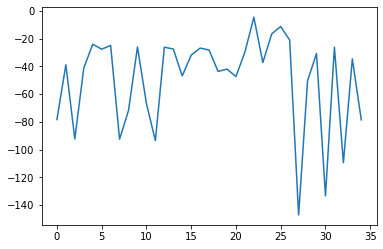

In [28]:
plt.plot(episode_reward)

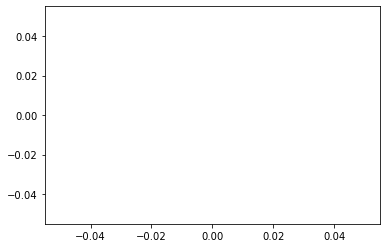

In [29]:
avg_reward = []
sum_reward = 0
span = 100
for i in range(len(episode_reward)): 
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

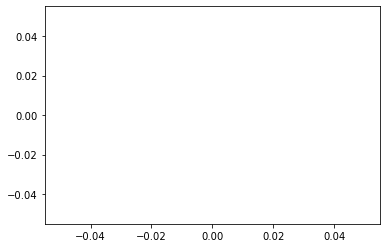

In [30]:
avg_reward = []
sum_reward = 0
span = 50
for i in range(len(episode_reward)):
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

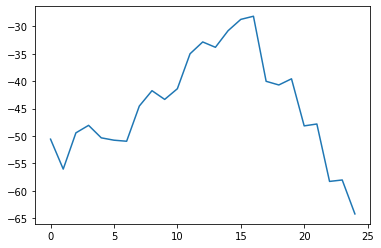

In [31]:
avg_reward = []
sum_reward = 0
span = 10
for i in range(len(episode_reward)):
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

In [ ]:
# agent.save_weights('ddpg_{}_weights.h5f'.format('32_3_rays_final'), overwrite=True)
# actor.save_weights('actor_32_3_rays_final.h5', overwrite=True) 
# critic.save_weights('critic_32_3_rays_final.h5', overwrite=True)

In [ ]:
env.make_obstacles()
env.reset()

In [ ]:
p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4, 'C:/Users/User/Desktop/Mars Bike/video.mp4')

In [ ]:
time.sleep(5.)
_ = agent.test(env, nb_episodes=10, visualize=True) #, nb_max_episode_steps=1000)

In [ ]:
p.stopStateLogging(2)

In [ ]:
# actor.save_weights('actor_32_3_rays_final.h5', overwrite=True) 
# critic.save_weights('critic_32_3_rays_final.h5', overwrite=True)

In [ ]:
actor.load_weights('actor_32_3_rays_final.h5')
critic.load_weights('critic_32_3_rays_final.h5')

In [ ]:
agent.load_weights('ddpg_{}_weights.h5f'.format('32_3_rays_final'))